# Load Libraries

In [43]:
import os
import warnings
import logging
import sys
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import dotenv
import pyet
from linearmodels.panel import PanelOLS, RandomEffects
from linearmodels.panel import compare

# Load environment variables from .env file
dotenv.load_dotenv()

# Set up logging
logging.basicConfig(level=logging.INFO)

# Suppress warnings
warnings.filterwarnings("ignore")

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', None)

# Load Data

In [44]:
# Load Data From Pickle
with open('../../data/Data_Iran_ETo_1983_2022.pkl', 'rb') as f:
    data = pickle.load(f)
    logging.info("Data loaded from pickle file.")

INFO:root:Data loaded from pickle file.


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6252652 entries, 0 to 6252651
Data columns (total 36 columns):
 #   Column             Dtype         
---  ------             -----         
 0   date               datetime64[ns]
 1   station_id         object        
 2   station_name       object        
 3   region_id          object        
 4   region_name        object        
 5   lat                float64       
 6   lon                float64       
 7   station_elevation  float64       
 8   tmax               float64       
 9   tmin               float64       
 10  tm                 float64       
 11  umax               float64       
 12  umin               float64       
 13  um                 float64       
 14  ffm                float64       
 15  sshn               float64       
 16  rrr24              float64       
 17  Penman             float64       
 18  FAO-56             float64       
 19  Priestley-Taylor   float64       
 20  Kimberly-Penman    float

# Panel Data Model

In [46]:
# Make sure date is datetime
data['date'] = pd.to_datetime(data['date'])

# Set multi-index: (station, time)
data = data.set_index(['station_id', 'date']).sort_index()

# Drop missing values
panel_df = data[['FAO-56', 'tmin', 'tmax', 'tm', 'um', 'ffm', 'sshn', 'rrr24', 'Hargreaves', 'lat', 'station_elevation']].dropna()

# Dependent variable
y = panel_df['FAO-56']

# Independent variables (add constant automatically)
X = panel_df[['tm', 'tmin', 'tmax', 'Hargreaves']]
X = X.assign(const=1)

#### Fit Fixed Effects Model

In [47]:
mod = PanelOLS(y, X, entity_effects=True)
fe_res = mod.fit(cov_type='clustered', cluster_entity=True)
print(fe_res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 FAO-56   R-squared:                        0.8021
Estimator:                   PanelOLS   R-squared (Between):              0.5683
No. Observations:             2454510   R-squared (Within):               0.8021
Date:                Sun, Sep 14 2025   R-squared (Overall):              0.7649
Time:                        18:07:28   Log-likelihood                -3.916e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   2.487e+06
Entities:                         362   P-value                           0.0000
Avg Obs:                       6780.4   Distribution:               F(4,2454144)
Min Obs:                       1.0000                                           
Max Obs:                    1.448e+04   F-statistic (robust):             3410.4
                            

### Fit Random Effects Model

In [48]:
re_mod = RandomEffects(y, X)
re_res = re_mod.fit()
print(re_res.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 FAO-56   R-squared:                        0.8021
Estimator:              RandomEffects   R-squared (Between):              0.5712
No. Observations:             2454510   R-squared (Within):               0.8021
Date:                Sun, Sep 14 2025   R-squared (Overall):              0.7643
Time:                        18:08:15   Log-likelihood                -3.916e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   2.487e+06
Entities:                         362   P-value                           0.0000
Avg Obs:                       6780.4   Distribution:               F(4,2454505)
Min Obs:                       1.0000                                           
Max Obs:                    1.448e+04   F-statistic (robust):          2.487e+06
                            

### Choose Between FE and RE

In [49]:
compare({'FE': fe_res, 'RE': re_res})

,FE,RE
Dep. Variable,FAO-56,FAO-56
Estimator,PanelOLS,RandomEffects
No. Observations,2454510,2454510
Cov. Est.,Clustered,Unadjusted
R-squared,0.8021,0.8021
R-Squared (Within),0.8021,0.8021
R-Squared (Between),0.5683,0.5712
R-Squared (Overall),0.7649,0.7643
F-statistic,2.487e+06,2.487e+06
P-value (F-stat),0.0000,0.0000


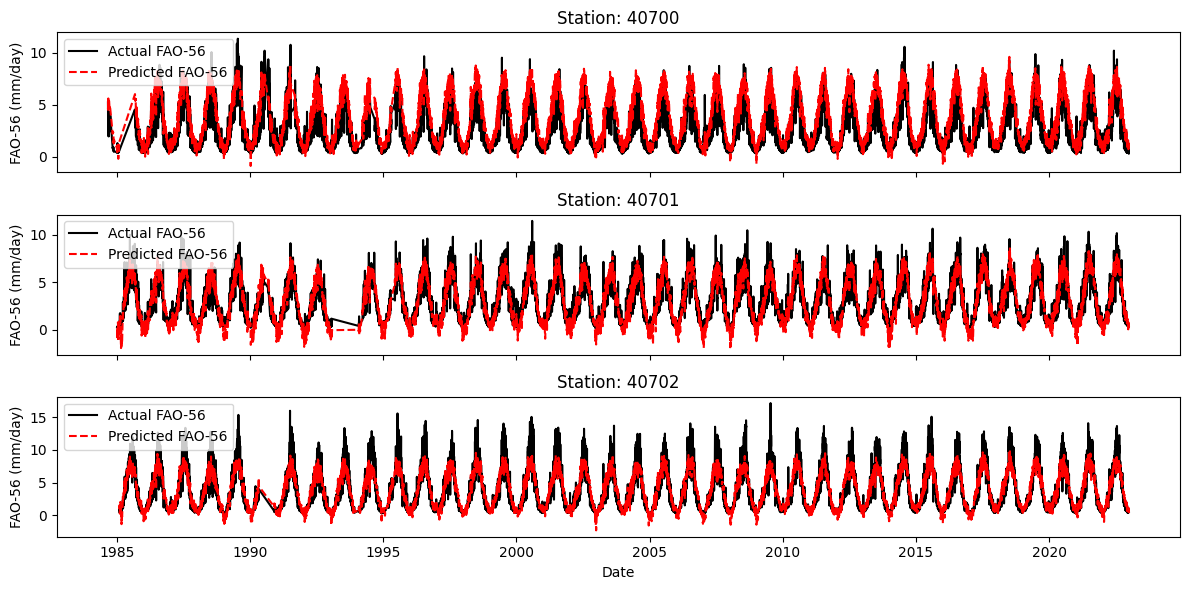

In [50]:
panel_df['FAO56_pred'] = fe_res.predict().fitted_values
stations_to_plot = panel_df.index.get_level_values(0).unique()[:3]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(stations_to_plot), 1, figsize=(12, 6), sharex=True)

for i, station in enumerate(stations_to_plot):
    data = panel_df.xs(station, level='station_id')
    
    axes[i].plot(data.index, data['FAO-56'], label="Actual FAO-56", color="black")
    axes[i].plot(data.index, data['FAO56_pred'], label="Predicted FAO-56", color="red", linestyle="--")
    axes[i].set_title(f"Station: {station}")
    axes[i].set_ylabel("FAO-56 (mm/day)")
    axes[i].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()

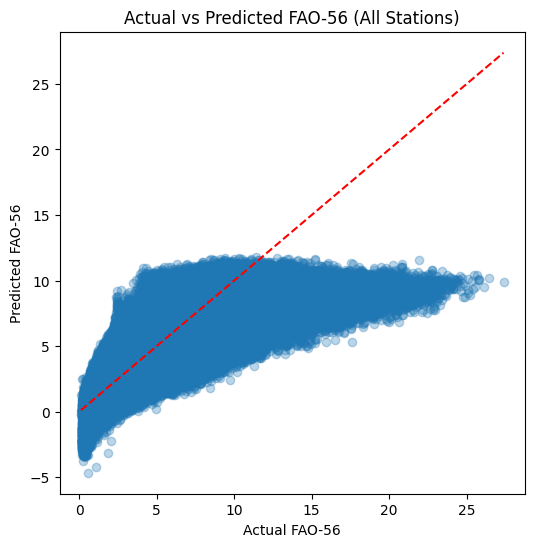

In [51]:
plt.figure(figsize=(6,6))
plt.scatter(panel_df['FAO-56'], panel_df['FAO56_pred'], alpha=0.3)
plt.plot([panel_df['FAO-56'].min(), panel_df['FAO-56'].max()],
         [panel_df['FAO-56'].min(), panel_df['FAO-56'].max()],
         color="red", linestyle="--")
plt.xlabel("Actual FAO-56")
plt.ylabel("Predicted FAO-56")
plt.title("Actual vs Predicted FAO-56 (All Stations)")
plt.show()

In [52]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Create a results DataFrame
station_metrics = []

for station in panel_df.index.get_level_values(0).unique():
    data = panel_df.xs(station, level='station_id')
    
    y_true = data['FAO-56']
    y_pred = data['FAO56_pred']
    
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    station_metrics.append({
        'station_id': station,
        'R2': r2,
        'RMSE': rmse
    })

station_results = pd.DataFrame(station_metrics).set_index('station_id')


In [54]:
import pandas as pd

# Top 10 stations by R²
print(station_results.sort_values('R2', ascending=False).head(10))
print(station_results.sort_values('R2', ascending=False).tail(10))

# Worst 10 stations by RMSE
print(station_results.sort_values('RMSE').head(10))
print(station_results.sort_values('RMSE').tail(10))


             R2  RMSE
station_id           
99236      0.93  0.76
40722      0.91  0.73
99283      0.91  0.67
99336      0.91  0.80
99266      0.91  0.68
99369      0.90  0.70
99270      0.90  0.88
40745      0.90  0.94
99385      0.89  0.87
40766      0.89  0.94
               R2  RMSE
station_id             
99276       -0.15  1.70
40719       -0.17  1.73
99272       -0.18  1.76
40737       -0.19  1.69
99309       -0.24  1.69
99999       -8.52  1.13
99203      -92.82  0.42
88104         NaN  2.97
99234         NaN  1.08
99308         NaN  1.04
               R2  RMSE
station_id             
99203      -92.82  0.42
99283        0.91  0.67
99266        0.91  0.68
99369        0.90  0.70
40712        0.89  0.71
40722        0.91  0.73
99236        0.93  0.76
99422        0.89  0.76
40730        0.89  0.77
99321        0.86  0.77
             R2  RMSE
station_id           
88122      0.44  2.65
40781      0.68  2.66
99402      0.60  2.66
88104       NaN  2.97
99437      0.49  3.20
40843 

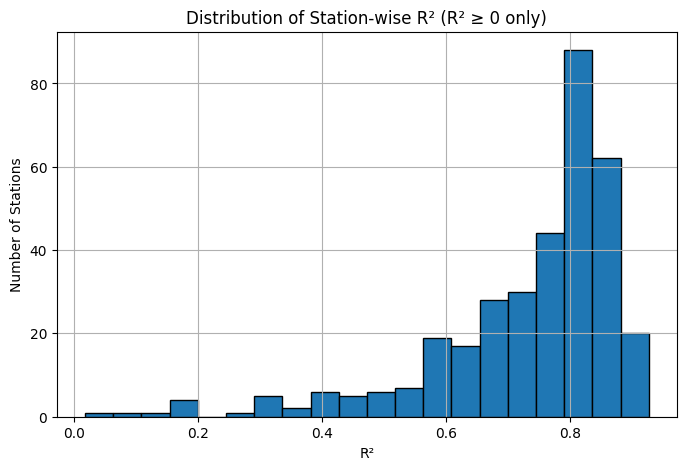

In [56]:
plt.figure(figsize=(8,5))

# Filter out negative R²
valid_r2 = station_results[station_results['R2'] >= 0]['R2']

valid_r2.hist(bins=20, edgecolor="black")

plt.xlabel("R²")
plt.ylabel("Number of Stations")
plt.title("Distribution of Station-wise R² (R² ≥ 0 only)")
plt.show()


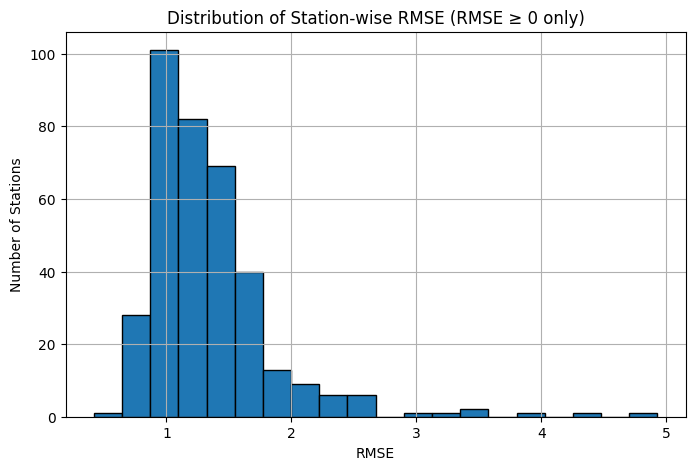

In [57]:
plt.figure(figsize=(8,5))

# Filter out negative R²
valid_r2 = station_results[station_results['RMSE'] >= 0]['RMSE']

valid_r2.hist(bins=20, edgecolor="black")

plt.xlabel("RMSE")
plt.ylabel("Number of Stations")
plt.title("Distribution of Station-wise RMSE (RMSE ≥ 0 only)")
plt.show()
